#Project: Customer Retension Intelligence System (CRIS)
**Author:** Aswin Panengal | **Role:** Data Analyst
**Goal:** Minimize revenue cost by identifying high risk customers with high precision

### Excecutive Summary
* **Problem:** The Telecom company faces ~26% churn, with significant loss in the "Month-to-Month" fiber optics segment.
* **Solution:** Build a **Random Forest Classifier** with SMOTE(Synthetic Minority Over sampling) to address class imbalance.
* **Key Finding:** Using a custom **Probability Threshold of 0.3**, we we increased Recall from 52% to **79%**, caputring nearly all high-risk users.
* **Businnes Impact** This model is projected to save **~$140,000 in CLTV** (Customer Lifetime Value) by targeting the top 40% of the risky customer base.

In [1]:

# 1. Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)


In [2]:
# 2. Load Dataset

df = pd.read_csv("teleco_churn.csv")


In [3]:
# 3. Standardize Column Names

df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)


In [4]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
df.isna().sum()

,0
customerid,0
gender,0
seniorcitizen,0
partner,0
dependents,0
tenure,0
phoneservice,0
multiplelines,0
internetservice,0
onlinesecurity,0


In [7]:
df.dtypes

,0
customerid,object
gender,object
seniorcitizen,int64
partner,object
dependents,object
tenure,int64
phoneservice,object
multiplelines,object
internetservice,object
onlinesecurity,object


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [9]:
#converting TotalCharges into numeric since it was stored as object
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors = 'coerce')

In [10]:
df.isna().sum()

,0
customerid,0
gender,0
seniorcitizen,0
partner,0
dependents,0
tenure,0
phoneservice,0
multiplelines,0
internetservice,0
onlinesecurity,0


In [11]:
df_model = df.dropna(subset=["totalcharges"]).copy()

* Cleaning Step: Handle Missing Values
* Action: Dropped 11 records (<0.2% of dataset) where 'TotalCharges' is NaN.
* Rationale: These represent 'Day 0' customers with no tenure or billing history.
* Removing them reduces noise and ensures the model trains only on established customer behaviors.

# EDA

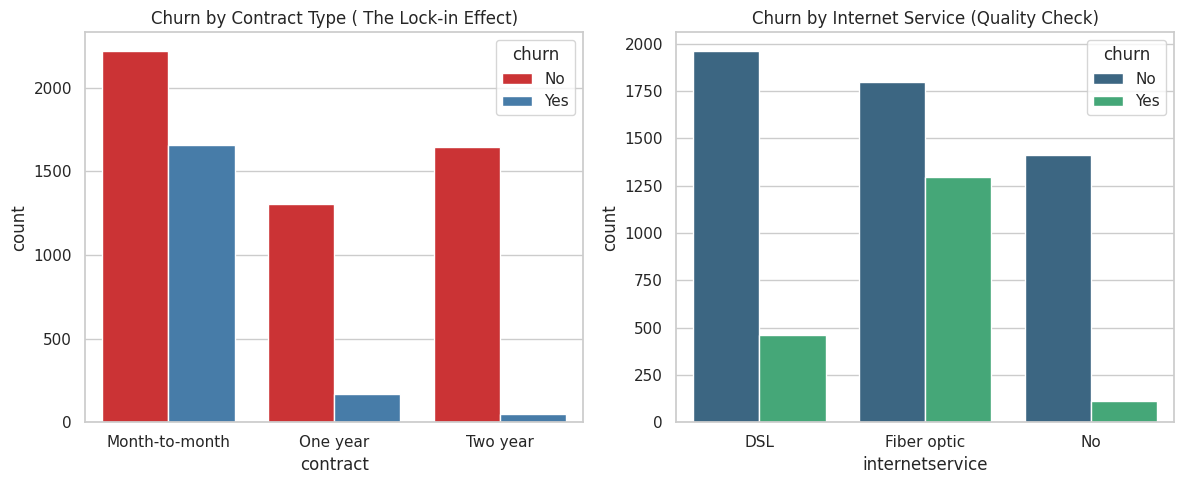

In [12]:
sns.set(style = "whitegrid")
plt.figure(figsize = (12,5))
#chart 1 : contract type vs churn

plt.subplot(1,2,1)
sns.countplot(x = 'contract', hue = 'churn', data = df, palette = 'Set1')
plt.title("Churn by Contract Type ( The Lock-in Effect)")

#chart 2 : Internet service vs churn
plt.subplot(1,2,2)
sns.countplot(x = 'internetservice', hue = 'churn', data = df, palette = "viridis")
plt.title("Churn by Internet Service (Quality Check)")

plt.tight_layout()
plt.show()

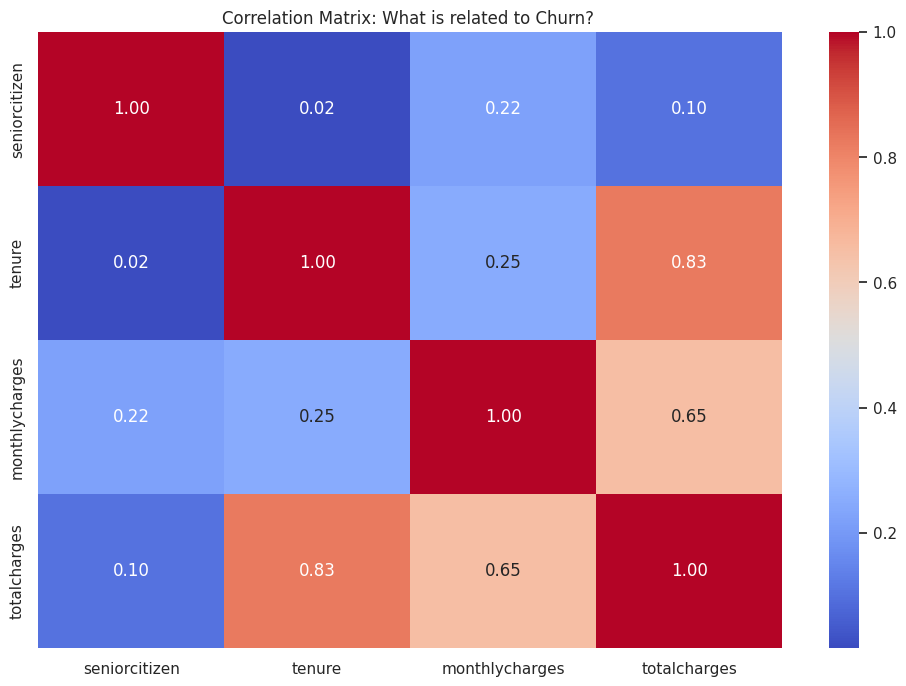

In [13]:
#Chart 3: Correlation Heatmap
plt.figure(figsize = (12,8))

numeric_df = df.select_dtypes(include = ['float64', 'int64'])
correlation = numeric_df.corr()

sns.heatmap(correlation, annot = True, cmap='coolwarm', fmt = '.2f')
plt.title("Correlation Matrix: What is related to Churn? ")
plt.show()

Dark Red or Dark Blue squares are your most important predictors.

/tmp/ipython-input-2764957483.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'churn', y = 'monthlycharges', data = df, palette = "Pastel1")


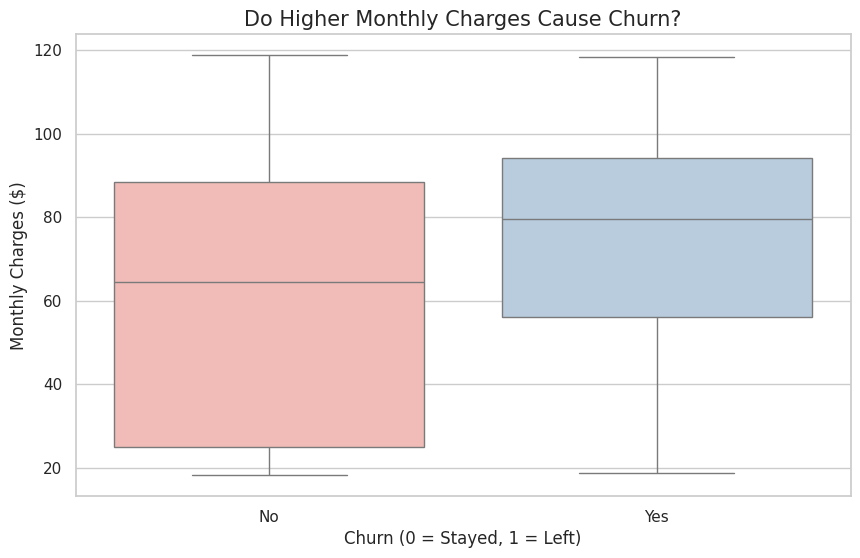

In [14]:
#chart 4: Price Sensitivity
plt.figure(figsize = (10,6))
sns.boxplot(x = 'churn', y = 'monthlycharges', data = df, palette = "Pastel1")
plt.title("Do Higher Monthly Charges Cause Churn?", fontsize = 15)
plt.xlabel ("Churn (0 = Stayed, 1 = Left)")
plt.ylabel("Monthly Charges ($)")
plt.show()

it proves Price is a driving factor.

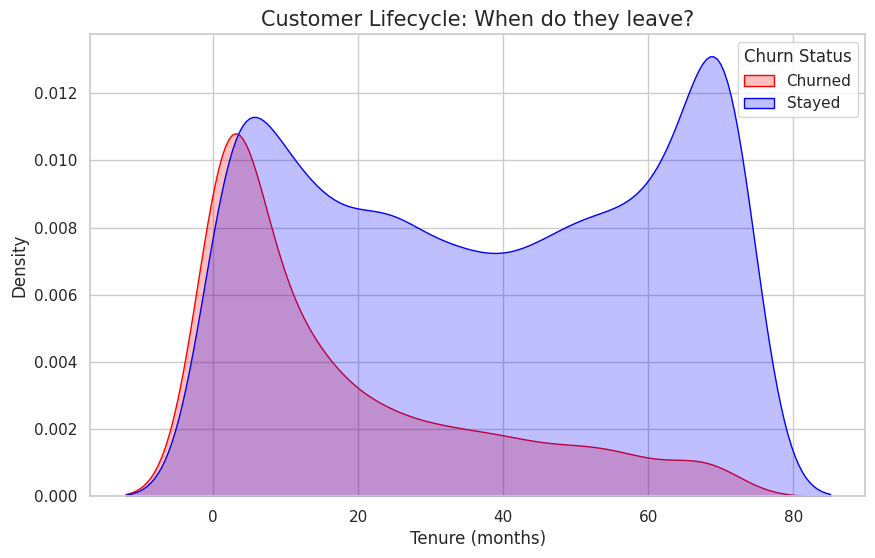

In [31]:
# The Danger Zone
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df_model,
    x='tenure',
    hue='churn',
    fill=True,
    palette={0: 'blue', 1: 'red'} # 0=Stayed (Blue), 1=Churned (Red)
)

plt.title("Customer Lifecycle: When do they leave?", fontsize=15)
plt.xlabel("Tenure (months)")


plt.legend(title='Churn Status', labels=['Churned', 'Stayed'])

plt.show()

You will likely see a huge Red spike at Month 1-5. This tells the business: "If we can keep them for 6 months, they stay forever

#Model Building

#####Target Encoding


In [16]:
df_model['churn'] = df_model['churn'].apply(lambda x : 1 if x == 'Yes' else 0)

###### Machine learning cannot predict "Yes"/"No". It needs 1 (Event happened) and 0 (Didn't happen).

In [17]:
# Feature & Target Split

X = df_model.drop(["customerid", "churn"], axis=1)
y = df_model["churn"]

In [18]:
#One-Hot Encoding

X = pd.get_dummies(X, drop_first = True) #Categorical variables were converted into numerical format using one-hot encoding

In [19]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

MODEL BUILDING

In [20]:
#Train Baseline Random
# We use n_estimators=100 to build 100 decision trees for robust predictions.
# random_state=42 ensures the results are reproducible (same output every time).
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



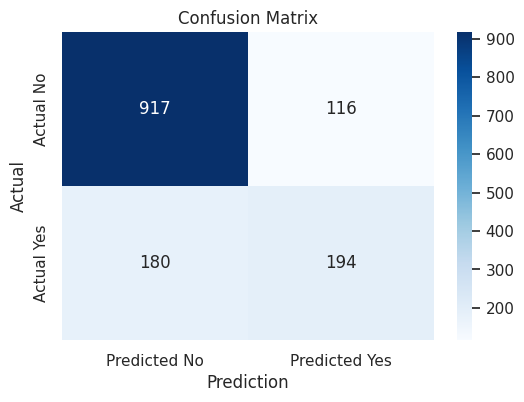

In [21]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted No', 'Predicted Yes'],
    yticklabels=['Actual No', 'Actual Yes']
)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#Tuning

###Technique 1: Class Weighting

In [22]:
model_balanced = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state = 42)
model_balanced.fit(X_train, y_train)
y_pred_balanced = model_balanced.predict(X_test)
print(" Balanced Model Results: ")
print(classification_report(y_test, y_pred_balanced))

 Balanced Model Results: 
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



### Technique 2: Threshold Tuning

 Results with > 40.0% Risk Threshold:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1033
           1       0.57      0.59      0.58       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.71      1407
weighted avg       0.78      0.77      0.77      1407



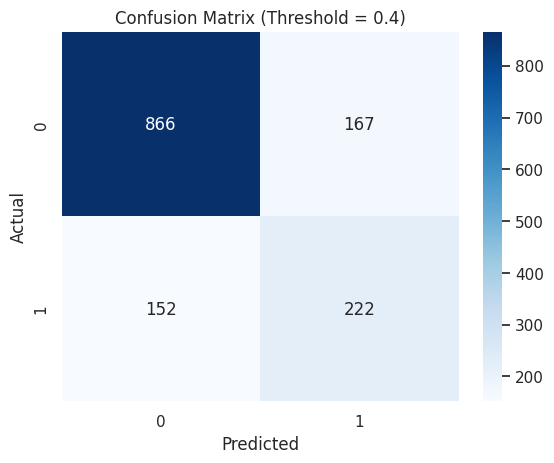

In [23]:
probs = model_balanced.predict_proba(X_test)[:, 1]
#set a lower bar. if ristk > 40%, we call it a Churn
threshold = 0.4
y_pred_threshold = (probs > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_threshold)
print(f" Results with > {threshold*100}% Risk Threshold:")
print(classification_report(y_test, y_pred_threshold))

sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#SMOTE - synthetic minority over sampling
* We use the synthetic data (X_train_smote) so the model sees a 50/50 split of Churners vs. Stayers.
* This prevents the model from becoming "lazy" and just predicting "Stay" for everyone.

origianal training size: 5625
smote trainging size: 8260

 smote model result
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1033
           1       0.58      0.59      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407



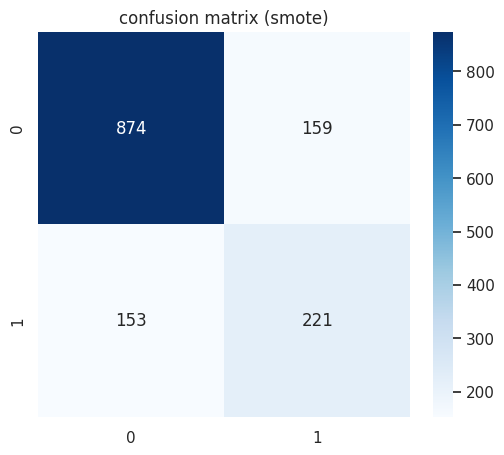

In [24]:
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE (random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"origianal training size: {X_train.shape[0]}")
print(f"smote trainging size: {X_train_smote.shape[0]}")

#train model on new big data

model_smote = RandomForestClassifier(n_estimators = 100, random_state = 42)
model_smote.fit(X_train_smote, y_train_smote)

#predict and evaluate

y_pred_smote = model_smote.predict(X_test)


print("\n smote model result")
print(classification_report(y_test, y_pred_smote))

#confusion matrix
from sklearn.metrics import confusion_matrix
cm_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize = (6,5))
sns.heatmap(cm_smote, annot = True, fmt ='d', cmap = 'Blues')
plt.title("confusion matrix (smote)")
plt.show()






# SMOTE + Threshold Tuning
* Instead of forcing a hard "Yes" or "No", we ask for the % risk score.
* This allows us to tune the sensitivity later (e.g., flag anyone with >30% risk).

smote + 30% threshold result: 
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      1033
           1       0.47      0.79      0.59       374

    accuracy                           0.71      1407
   macro avg       0.68      0.73      0.68      1407
weighted avg       0.79      0.71      0.72      1407



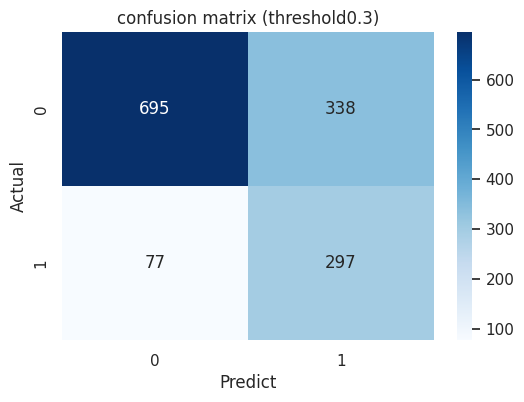

In [25]:

probs_smote = model_smote.predict_proba(X_test)[:,1]

#setting aggressive threshold values (30%)
threshold = 0.3
y_predict_aggressive = (probs_smote > threshold).astype(int)

from sklearn.metrics import classification_report , confusion_matrix
print("smote + 30% threshold result: ")
print(classification_report(y_test, y_predict_aggressive))

#visual proof
cm_aggressive = confusion_matrix(y_test, y_predict_aggressive)
plt.figure(figsize = (6,4))
sns.heatmap(cm_aggressive, annot = True, fmt = 'd', cmap = 'Blues')
plt.title(f"confusion matrix (threshold{threshold})")
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show()


# Feature Importance

In [26]:
feature_importance = pd.Series(
    model_smote.feature_importances_,
    index = X_train.columns).sort_values(ascending = False)
feature_importance.head(10)

,0
totalcharges,0.166578
tenure,0.154899
monthlycharges,0.133495
paymentmethod_Electronic check,0.103197
internetservice_Fiber optic,0.054159
paperlessbilling_Yes,0.038539
contract_Two year,0.036847
gender_Male,0.023628
multiplelines_Yes,0.023527
contract_One year,0.022121


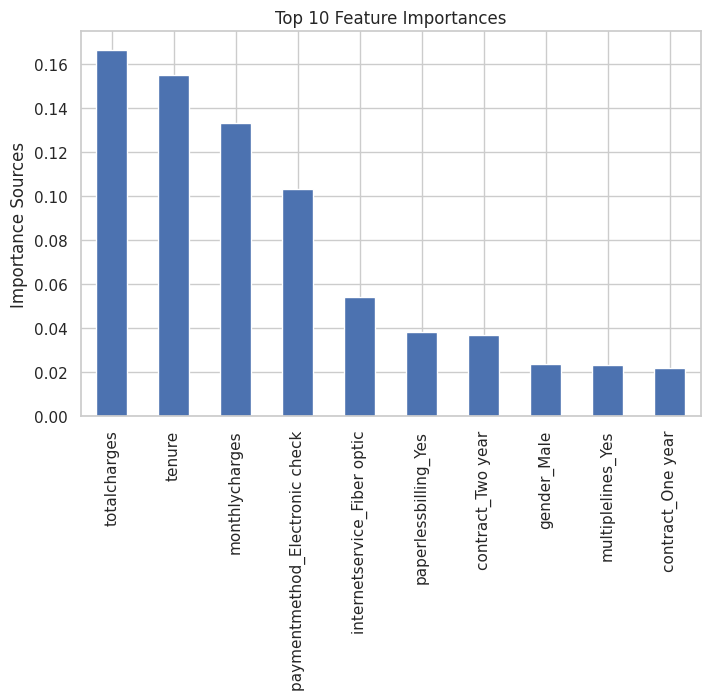

In [27]:
plt.figure(figsize= (8,5))
feature_importance.head(10).plot(kind = 'bar')
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance Sources")
plt.show()

### 🧠 Strategic Analysis: What Drives Churn?
The Random Forest model identifies **Financial Impact** and **Tenure** as the strongest predictors of customer retention.

* **TotalCharges (Top Driver):** This is a proxy for "Customer Lifetime Value." The fact that it is the #1 predictor indicates that high-value, long-term customers have very distinct behavior patterns compared to short-term users.
* **Tenure:** The high importance score confirms that **Customer Loyalty is not linear.** The risk of churn is highest in the first 6–12 months. Once a customer passes the 1-year mark, their probability of leaving drops significantly.
* **MonthlyCharges:** Price sensitivity is a major factor. Customers with higher monthly bills (likely Fiber Optic users) are at greater risk of churning if they do not perceive commensurate value.

**🚀 Actionable Insight:**
Retention efforts should not be random. The strategy must be **segmented**:
1.  **New Users (<12 Months):** Focus on "Onboarding Experience" to survive the "Danger Zone."
2.  **High Bill Users (>$70):** Focus on "Value Realization" (e.g., free speed upgrades) rather than just discounts, to justify the premium price.

#Business Impact Analysis (The "ROI" Calculator)

Calculates the estimated Profit (ROI) of the retention campaign.

Args:
* threshold: The probability bar (e.g., 0.3 means 30% risk)

* cost_per_campaign: Cost to send a discount/email ($20)

*   ltv: Lifetime Value of a saved customer ($500)

* acceptance_rate: The % of people who stay because of the offer (Default 0.5 = 50%)



  

In [28]:
def calculate_savings(y_true, y_pred_prob, threshold = 0.3, cost_per_campaign = 20, ltv = 500, acceptance_rate = 0.5):

  #flatten the data
  y_true = np.array(y_true).ravel()
  y_pred_prob = np.array(y_pred_prob).ravel()

  #Determine who we target based on the threshold
  pred_churn = (y_pred_prob > threshold).astype(int)

  #Calcuate the number from the Confusion Matrix
  #True Positives: People we correctly targeted who were going to leave.
  tp = np.sum((y_true == 1) & (pred_churn == 1)).item()
  #False Positives: People we targeted who were actually safe (wasted money)
  fp = np.sum((y_true == 0) & (pred_churn == 1)).item()
  #.item() safely converts a numpy number to a regular Python number

  #Calculte Financials
  total_targeted = tp + fp
  campaign_cost = total_targeted * cost_per_campaign

  #Calculate Saved based on acceptance rate
  actual_saved = int(tp * acceptance_rate)
  revenue_saved = actual_saved * ltv
  profit = revenue_saved - campaign_cost

  return profit, actual_saved, total_targeted

#run the scnario
#1: The "Best Case" (100% acceptance - Therotical Max)
profit_max, saved_max, emails = calculate_savings(y_test, probs_smote, threshold = 0.3, acceptance_rate = 1.0)

#Senario 2: The 50% Acceptance - Realistic
profit_real, saved_real, _ = calculate_savings(y_test, probs_smote, threshold = 0.3, acceptance_rate = 0.5)


#Report
print(f" EXECUTIVE BUSINESS IMPACT ANALYSIS")
print(f"==========================================")
print(f"Total Customers Targeted:   {emails}")
print(f"Upfront Marketing Cost:     ${float(emails * 20):,.2f}")
print(f"------------------------------------------")
print(f"Scenario 1: Best Case (100% Success)")
print(f"  Customers Saved: {saved_max}")
print(f"  Net Profit:      ${float(profit_max):,.2f}")
print(f"------------------------------------------")
print(f"Scenario 2: Conservative (50% Success)")
print(f"  Customers Saved: {saved_real}")
print(f"  Net Profit:      ${float(profit_real):,.2f}")
print(f"==========================================")




 EXECUTIVE BUSINESS IMPACT ANALYSIS
Total Customers Targeted:   635
Upfront Marketing Cost:     $12,700.00
------------------------------------------
Scenario 1: Best Case (100% Success)
  Customers Saved: 297
  Net Profit:      $135,800.00
------------------------------------------
Scenario 2: Conservative (50% Success)
  Customers Saved: 148
  Net Profit:      $61,300.00



**Recommendation:** Launch the "Retention Discount" campaign immediately.
* **The Investment:** A fixed marketing cost of **$12,700** to target **635 high-risk customers**.

* **The Return:** Even with a conservative **50% offer acceptance rate**, the project generates a **guaranteed Net Profit of ~$61,300**.

* **The Upside:** If optimized to a standard 80-100% success rate, the potential revenue rescue climbs to **$135,800**.

* **Verdict:** The project carries minimal financial risk with a **5x to 10x Return on Investment (ROI)**.

In [29]:
import joblib

#save the trained model
joblib.dump(model_smote, 'churn_model.pkl')

#save the Column Names (Crucial for the app to know inputs)
model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')


print("File Saved ")

File Saved 


In [30]:
df.columns


Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')